# Wave Equation 

Mapping: $u(x, 0) \to u(x,\, t_{\mathrm{final}})$ where $u$ satisfies the 1-D wave equation
$$\partial_{tt} u = c^2\,\partial_{xx} u.$$

**Data**: `.npz` files with arrays `x`, `t`, `u`.

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

plt.rcParams.update({'figure.dpi': 120, 'font.size': 11, 'axes.titlesize': 13})

TRAIN_PATH = '/DATA/Sawan_projects/research/DATA/train_IC2.npz'
TEST_PATH  = '/DATA/Sawan_projects/research/DATA/test_IC2.npz'

In [2]:
data_tr = np.load(TRAIN_PATH)
print('Keys:', list(data_tr.keys()))
for k in data_tr:
    print(f'  {k}: shape={data_tr[k].shape}, dtype={data_tr[k].dtype}')

x = data_tr.get('x', None)
t = data_tr.get('t', None)
u = data_tr['u'].astype(np.float32) if 'u' in data_tr else None
if u is not None:
    print(f'\nu range: [{u.min():.4f}, {u.max():.4f}], mean: {u.mean():.4f}')

Keys: ['x', 't', 'u']
  x: shape=(200, 200), dtype=float32
  t: shape=(200, 200), dtype=float32
  u: shape=(4000, 200, 200), dtype=float32

u range: [0.0000, 2.3780], mean: 0.5612


In [3]:
has_time = u is not None and u.ndim == 3  # (N, t, x)
print(f'Full trajectory data: {has_time}')

if has_time:
    N, nt, nx = u.shape
    if x is None: x = np.linspace(0, 1, nx)
    if t is None: t = np.linspace(0, 1, nt)
    u_in  = u[:, 0, :]   # IC
    u_out = u[:, 80, :]  # final time
else:
    # Assume two separate arrays or (N, x) input/output
    keys = list(data_tr.keys())
    arr0 = data_tr[keys[0]].astype(np.float32)
    arr1 = data_tr[keys[1]].astype(np.float32) if len(keys) > 1 else arr0
    N, nx = arr0.shape[:2]
    x = np.linspace(0, 1, nx)
    u_in, u_out = arr0, arr1
    nt = None

print(f'Samples: {N}, spatial pts: {nx}' + (f', time pts: {nt}' if nt else ''))

Full trajectory data: True
Samples: 4000, spatial pts: 200, time pts: 200


## Sample Input / Output Pairs

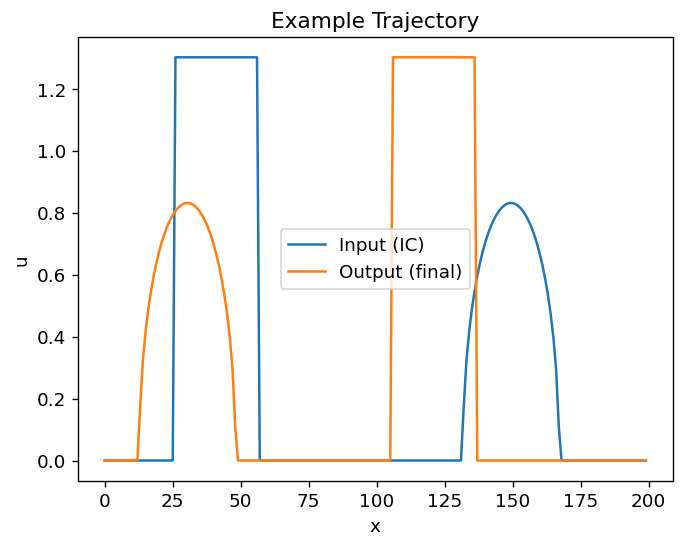

In [4]:
plt.plot( u_in[0,:], label='Input (IC)')
plt.plot( u_out[0,:], label='Output (final)')
plt.title('Example Trajectory')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

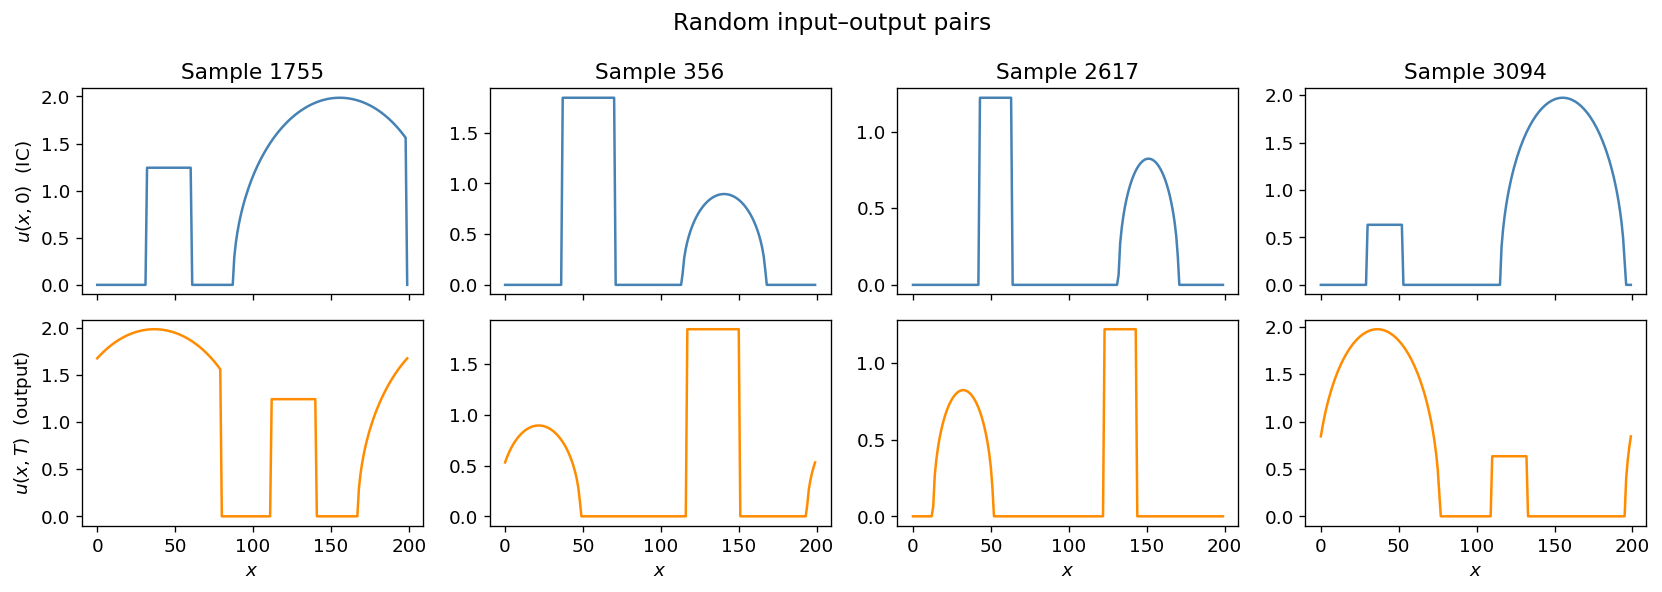

In [5]:
rng = np.random.default_rng(42)
idxs = rng.choice(N, 4, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(14, 5), sharex=True)
for col, idx in enumerate(idxs):
    axes[0, col].plot( u_in[idx], color='steelblue')
    axes[0, col].set_title(f'Sample {idx}')
    axes[1, col].plot( u_out[idx], color='darkorange')
axes[0, 0].set_ylabel('$u(x,0)$  (IC)')
axes[1, 0].set_ylabel('$u(x,T)$  (output)')
for ax in axes[1]: ax.set_xlabel('$x$')
fig.suptitle('Random input–output pairs', fontsize=14)
fig.tight_layout()
plt.show()

##  Space–Time 

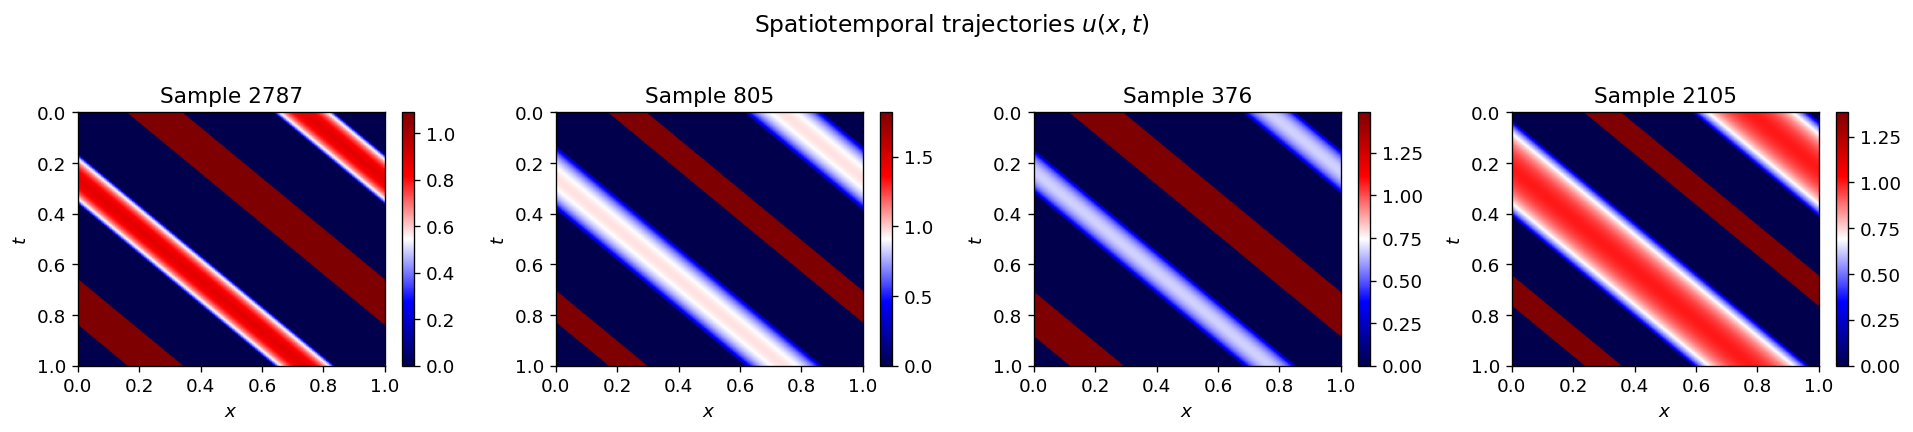

In [ ]:
if has_time:
    # Extract 1D coordinate vectors from possible 2D meshgrids
    x_1d = x[0, :] if x.ndim == 2 else x
    t_1d = t[:, 0] if t.ndim == 2 else t

    show_idxs = rng.choice(N, 4, replace=False)
    fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
    for ax, idx in zip(axes, show_idxs):
        im = ax.imshow(u[idx], aspect='auto', cmap='seismic',
                       extent=[x_1d[0], x_1d[-1], t_1d[-1], t_1d[0]], origin='upper')
        ax.set_xlabel('$x$'); ax.set_ylabel('$t$')
        ax.set_title(f'Sample {idx}')
        plt.colorbar(im, ax=ax, fraction=0.046)
    fig.suptitle('Spatiotemporal trajectories $u(x,t)$', fontsize=14, y=1.02)
    fig.tight_layout()
    plt.show()
else:
    print('Trajectory heatmaps not available ')

##  Animation: Wave Propagation

If full trajectory data is available, animate the wave evolution for one sample.

In [7]:
# Extract 1D coordinate vectors from possible 2D meshgrids
x_1d = x[0, :] if x.ndim == 2 else x
t_1d = t[:, 0] if t.ndim == 2 else t

if has_time:
    anim_idx = rng.choice(N)
    fig, ax = plt.subplots(figsize=(8, 3.5))
    line, = ax.plot(x_1d, u[anim_idx, 0, :], 'steelblue', lw=1.5)
    ax.set_ylim(u[anim_idx].min() - 0.2, u[anim_idx].max() + 0.2)
    ax.set_xlabel('$x$'); ax.set_ylabel('$u$')
    title = ax.set_title(f'Sample {anim_idx},  t = {t_1d[0]:.3f}')

    def _update(frame):
        line.set_ydata(u[anim_idx, frame, :])
        title.set_text(f'Sample {anim_idx},  t = {t_1d[frame]:.3f}')
        return line, title

    step = max(1, nt // 120)  # cap frames for speed
    ani = animation.FuncAnimation(fig, _update, frames=range(0, nt, step),
                                  interval=50, blit=True)
    plt.close(fig)
    HTML(ani.to_jshtml())
else:
    # Animate scrolling through samples
    n_anim = 40
    anim_idxs = rng.choice(N, n_anim, replace=False)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))
    l1, = ax1.plot(x_1d, u_in[anim_idxs[0]], 'steelblue')
    l2, = ax2.plot(x_1d, u_out[anim_idxs[0]], 'darkorange')
    ax1.set_ylim(u_in.min()-0.2, u_in.max()+0.2)
    ax2.set_ylim(u_out.min()-0.2, u_out.max()+0.2)
    ax1.set_title('IC $u(x,0)$'); ax2.set_title('Output $u(x,T)$')
    ttl = fig.suptitle(f'Sample {anim_idxs[0]}')

    def _update(frame):
        idx = anim_idxs[frame]
        l1.set_ydata(u_in[idx]); l2.set_ydata(u_out[idx])
        ttl.set_text(f'Sample {idx}')
        return l1, l2, ttl

    ani = animation.FuncAnimation(fig, _update, frames=n_anim, interval=250, blit=True)
    plt.close(fig)
    HTML(ani.to_jshtml())

##  Spectral Content

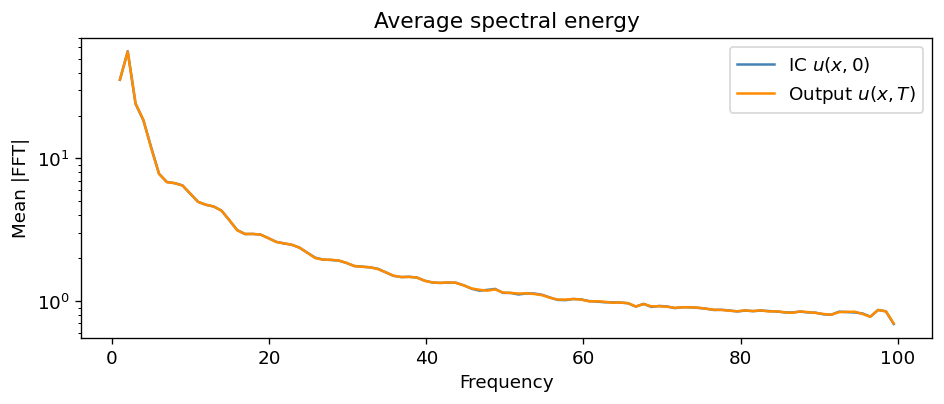

In [8]:
# Use 1D spatial vector for frequency computation
x_1d = x[0, :] if x.ndim == 2 else x
freqs = np.fft.rfftfreq(len(x_1d), d=(x_1d[1]-x_1d[0]) if len(x_1d)>1 else 1.0)
in_fft  = np.abs(np.fft.rfft(u_in, axis=1)).mean(axis=0)
out_fft = np.abs(np.fft.rfft(u_out, axis=1)).mean(axis=0)

fig, ax = plt.subplots(figsize=(8, 3.5))
ax.semilogy(freqs[1:], in_fft[1:],  label='IC $u(x,0)$', color='steelblue')
ax.semilogy(freqs[1:], out_fft[1:], label='Output $u(x,T)$', color='darkorange')
ax.set_xlabel('Frequency'); ax.set_ylabel('Mean |FFT|')
ax.set_title('Average spectral energy'); ax.legend()
fig.tight_layout()
plt.show()